In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

**Generate Data**

In [3]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)

print(f"Dataset shape: {x.shape}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (1000, 2)
Classes: [0 1]
Class distribution: [501 499]


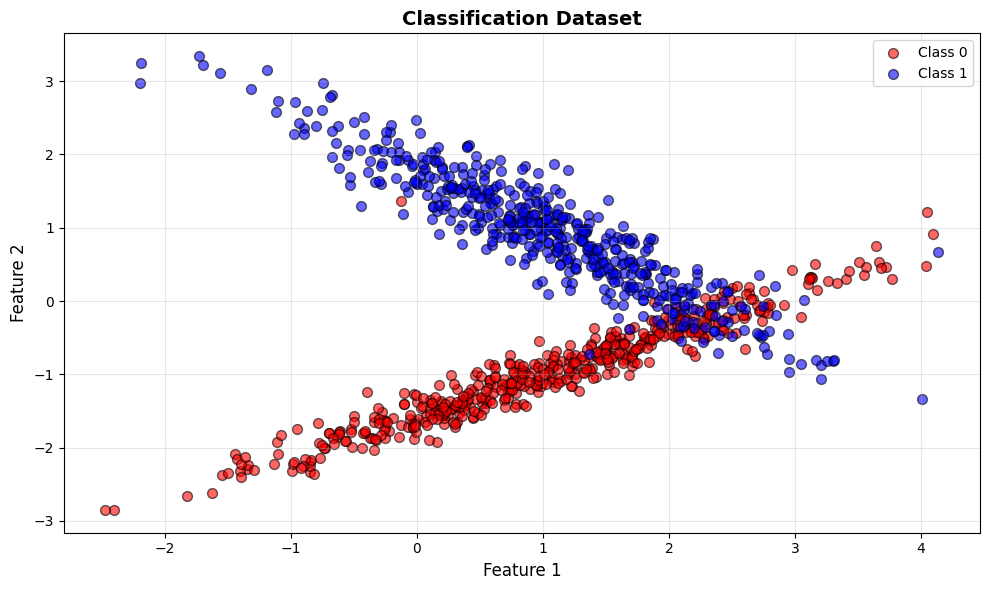

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(x[y == 0, 0], x[y == 0, 1], c='red', alpha=0.6, s=50, label='Class 0', edgecolors='black')
plt.scatter(x[y == 1, 0], x[y == 1, 1], c='blue', alpha=0.6, s=50, label='Class 1', edgecolors='black')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Classification Dataset', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Preprocess Data**

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
# Reshape y for neural network
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Training set: {x_train_scaled.shape}")
print(f"Test set: {x_test_scaled.shape}")
print(f"Target training set: {y_train.shape}")

Training set: (800, 2)
Test set: (200, 2)
Target training set: (800, 1)


**Define Neural Network Class**

In [ ]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, activation='sigmoid'):
         self.layers = layers
         self.learning_rate = learning_rate
         self.activation = activation
         self.weights = []
         self.biases = []
         self.history = {'loss' : [], 'accuracy' : []}
         
         # Xavier initialization for sigmoid, He for ReLU
         for i in range(len(layers) - 1):
            if activation == 'relu':
                 std = np.sqrt(2.0 / layers[i])
            else:
                std = np.sqrt(1.0 / layers[i])
            
            w = np.random.randn(layers[i], layers[i+1]) * std
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def activate(self, x):
        if self.activation == 'relu':
            return self.relu(x)
        return self.sigmoid(x)
    
    def activate_derivative(self, x):
        if self.activation == 'relu':
            return self.relu_derivative(x)
        return self.sigmoid_derivative(x)